<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/NY_TimeSeriesAnalysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab uses the labeled NY data from the following csv files:
* NY covid cases + mobility + population density + social distancing index (m50) + Mask rule  data and classified : **NY_labeledData_Aug27.csv**
* NY covid cases with social distancing inertia data from Marlyland university and classified : **NY_sd_inertia_labeledData_Aug27.csv**

Idea: 
* Do Time Series Analysis, Visualization & Forecasting with LSTM


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [ ]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA
CA_combined_Sep09.csv
CA_combined_Sep25.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_labeledData_Oct09.csv
CA_labeledData_Oct10.csv
CA_labeledData_Sep09
CA_labeledData_Sep18.csv
CA_labeledData_Sep20.csv
CA_labeledData_Sep22.csv
CA_labeledData_Sep25.csv
CA_labeledData_Sep26.csv
CA_labeledData_Sep29.csv
CA_sd_inertia_labeledData_Sep09
CA_sd_inertia_labeledData_Sep18.csv
CA_sd_inertia_labeledData_Sep20.csv
CA_sd_inertia_labeledData_Sep22.csv
CA_sd_inertia_labeledData_Sep25.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
Newyork_combinedSep24.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_labeledData_Sep26.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Sep26.csv
NY_socialDistancingInertiaDataAug25.c

In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 


# 1.1 Loading NY Labeled data

In [ ]:
NY_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Sep26.csv',low_memory=False)
NY_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
0,2020-03-01,36001,Albany County,10.0000,13.0000,19.0000,4.0000,7.0000,-1.0000,-4.8700,2.6160,54,584.3650,0,0.0000,0,0.0000,305506.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000
1,2020-03-01,36123,Yates County,31.0000,33.0000,0.0000,0.0000,7.0000,0.0000,28.1400,5.0040,72,73.6766,0,0.0000,0,0.0000,24913.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000
2,2020-03-01,36021,Columbia County,21.0000,4.0000,0.0000,25.0000,4.0000,0.0000,19.7500,5.3370,58,93.6822,0,0.0000,0,0.0000,59461.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000
3,2020-03-01,36095,Schoharie County,26.0000,9.0000,0.0000,0.0000,13.0000,0.0000,24.4700,2.1370,27,49.8520,0,0.0000,0,0.0000,30999.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000
4,2020-03-01,36033,Franklin County,28.0000,27.0000,0.0000,0.0000,7.0000,0.0000,10.8200,2.2050,56,30.7049,0,0.0000,0,0.0000,50022.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000


## Categorical Code

In [ ]:
NY_labeled_data["label"] = NY_labeled_data["label"].astype('category')
NY_labeled_data['spread_category']= NY_labeled_data["label"].cat.codes

In [ ]:
NY_labeled_data.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop,spread_category
0,2020-03-01,36001,Albany County,10.0000,13.0000,19.0000,4.0000,7.0000,-1.0000,-4.8700,2.6160,54,584.3650,0,0.0000,0,0.0000,305506.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000,0
1,2020-03-01,36123,Yates County,31.0000,33.0000,0.0000,0.0000,7.0000,0.0000,28.1400,5.0040,72,73.6766,0,0.0000,0,0.0000,24913.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000,0
2,2020-03-01,36021,Columbia County,21.0000,4.0000,0.0000,25.0000,4.0000,0.0000,19.7500,5.3370,58,93.6822,0,0.0000,0,0.0000,59461.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000,0
3,2020-03-01,36095,Schoharie County,26.0000,9.0000,0.0000,0.0000,13.0000,0.0000,24.4700,2.1370,27,49.8520,0,0.0000,0,0.0000,30999.0000,LessSpread,flat_growth,0.0000,flat_growth,0.0000,0


## Filter 'Nassau County'

In [ ]:
NY_labeled_data.columns

Index(['Date', 'fips_x', 'County Name', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases', 'population', 'label', 'growth_label',
       'New Cases/1k population', 'growth_label_1k', 'growth_1k_pop',
       'spread_category'],
      dtype='object')

In [ ]:
NY_labeled_data['County Name'].unique()

array(['Albany County', 'Yates County', 'Columbia County',
       'Schoharie County', 'Franklin County', 'Suffolk County',
       'Ontario County', 'Nassau County', 'Delaware County',
       'Madison County', 'Washington County', 'Chautauqua County',
       'Oswego County', 'Putnam County', 'Otsego County',
       'Schenectady County', 'Fulton County', 'Livingston County',
       'Dutchess County', 'Steuben County', 'Niagara County',
       'Oneida County', 'Warren County', 'Westchester County',
       'Cattaraugus County', 'Cayuga County', 'Chemung County',
       'Allegany County', 'Herkimer County', 'Clinton County',
       'Rockland County', 'Tioga County', 'Lewis County',
       'Schuyler County', 'Essex County', 'Wyoming County',
       'Broome County', 'New York County', 'St. Lawrence County',
       'Orange County', 'Montgomery County', 'Greene County',
       'Onondaga County', 'Tompkins County', 'Jefferson County',
       'Chenango County', 'Rensselaer County', 'Monroe County

In [ ]:
from datetime import datetime
# load data
def parse(x):
    #print(x)
    return datetime.strptime(x,'%Y-%m-%d')
 


In [ ]:
X_cols = ['retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases','Date']
#Y_col = ['Date']

In [ ]:
nassau_county_data = NY_labeled_data[NY_labeled_data['County Name'] == 'Nassau County'][X_cols]
print(nassau_county_data.shape)
nassau_county_data.head()

(172, 15)


,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,Date
7,6.0000,4.0000,-10.0000,-2.0000,2.0000,0.0000,-10.1000,3.9660,56,4765.8191,0,0.0000,0,0.0000,2020-03-01
86,4.0000,5.0000,26.0000,-6.0000,4.0000,-1.0000,1.2400,6.8790,98,4765.8191,0,0.0000,0,0.0000,2020-03-02
151,5.0000,3.0000,3.0000,-3.0000,3.0000,0.0000,9.3300,6.9070,99,4765.8191,0,0.0000,0,0.0000,2020-03-03
195,6.0000,7.0000,20.0000,-5.0000,3.0000,-1.0000,9.3900,6.9610,100,4765.8191,0,0.0000,0,0.0000,2020-03-04
273,5.0000,7.0000,25.0000,-2.0000,4.0000,0.0000,13.5000,7.2160,103,4765.8191,0,0.0000,1,0.0000,2020-03-05


In [ ]:
nassau_county_data['Date'] = nassau_county_data['Date'].apply(lambda x: parse(x))
nassau_county_data.index.name = 'Date'
nassau_county_data.head()

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,Date
Date,,,,,,,,,,,,,,,
7,6.0000,4.0000,-10.0000,-2.0000,2.0000,0.0000,-10.1000,3.9660,56,4765.8191,0,0.0000,0,0.0000,2020-03-01
86,4.0000,5.0000,26.0000,-6.0000,4.0000,-1.0000,1.2400,6.8790,98,4765.8191,0,0.0000,0,0.0000,2020-03-02
151,5.0000,3.0000,3.0000,-3.0000,3.0000,0.0000,9.3300,6.9070,99,4765.8191,0,0.0000,0,0.0000,2020-03-03
195,6.0000,7.0000,20.0000,-5.0000,3.0000,-1.0000,9.3900,6.9610,100,4765.8191,0,0.0000,0,0.0000,2020-03-04
273,5.0000,7.0000,25.0000,-2.0000,4.0000,0.0000,13.5000,7.2160,103,4765.8191,0,0.0000,1,0.0000,2020-03-05


In [ ]:
nassau_county_data['Date']

7       2020-03-01
86      2020-03-02
151     2020-03-03
195     2020-03-04
273     2020-03-05
           ...    
9540    2020-08-17
9632    2020-08-18
9664    2020-08-19
9725    2020-08-20
9764    2020-08-21
Name: Date, Length: 172, dtype: object

In [ ]:
values = nassau_county_data.values


In [ ]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
nassau_county_data.values[:,4]

array([2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 6.0, 1.0, 1.0, -2.0, -2.0, -4.0,
       -10.0, -1.0, -8.0, -28.0, -34.0, -37.0, -41.0, -44.0, -29.0, -37.0,
       -60.0, -59.0, -60.0, -61.0, -60.0, -47.0, -47.0, -63.0, -65.0,
       -65.0, -66.0, -66.0, -51.0, -50.0, -66.0, -67.0, -67.0, -69.0,
       -70.0, -52.0, -55.0, -68.0, -65.0, -65.0, -65.0, -63.0, -48.0,
       -45.0, -63.0, -62.0, -62.0, -62.0, -43.0, -45.0, -61.0, -61.0,
       -61.0, -61.0, -58.0, -39.0, -38.0, -58.0, -58.0, -57.0, -57.0,
       -56.0, -37.0, -34.0, -56.0, -56.0, -55.0, -55.0, -54.0, -33.0,
       -32.0, -53.0, -53.0, -53.0, -53.0, -52.0, -33.0, -29.0, -76.0,
       -51.0, -50.0, -50.0, -22.0, -21.0, -48.0, -48.0, -48.0, -48.0,
       -47.0, -21.0, -18.0, -46.0, -46.0, -45.0, -46.0, -44.0, -15.0,
       -15.0, -45.0, -45.0, -45.0, -45.0, -44.0, -15.0, -13.0, -46.0,
       -45.0, -43.0, -43.0, -43.0, -16.0, -12.0, -43.0, -43.0, -43.0,
       -43.0, -58.0, -33.0, -18.0, -46.0, -44.0, -42.0, -42.0, -44.0,
       -13.0, -

In [ ]:
nassau_county_data.dtypes

retail and recreation           float64
grocery and pharmacy            float64
parks                           float64
transit stations                float64
workplaces                      float64
residential                     float64
driving                         float64
m50                             float64
m50_index                         int64
population_density              float64
mask_rule_active                  int64
mask_wearing_percent            float64
New cases                         int64
rolling_avg_new_cases           float64
Date                     datetime64[ns]
dtype: object

In [ ]:
nassau_county_data.head()

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,Date
7,6.0000,4.0000,-10.0000,-2.0000,2.0000,0.0000,-10.1000,3.9660,56,4765.8191,0,0.0000,0,0.0000,2020-03-01
86,4.0000,5.0000,26.0000,-6.0000,4.0000,-1.0000,1.2400,6.8790,98,4765.8191,0,0.0000,0,0.0000,2020-03-02
151,5.0000,3.0000,3.0000,-3.0000,3.0000,0.0000,9.3300,6.9070,99,4765.8191,0,0.0000,0,0.0000,2020-03-03
195,6.0000,7.0000,20.0000,-5.0000,3.0000,-1.0000,9.3900,6.9610,100,4765.8191,0,0.0000,0,0.0000,2020-03-04
273,5.0000,7.0000,25.0000,-2.0000,4.0000,0.0000,13.5000,7.2160,103,4765.8191,0,0.0000,1,0.0000,2020-03-05


In [ ]:
len(X_cols)

15

## Preprocessing data for LSTM

In [ ]:
values = nassau_county_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,14] = encoder.fit_transform(values[:,14])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var13(t)  var14(t)  var15(t)
1     1.0000     0.6265     0.1380  ...    0.0000    0.0000    0.0058
2     0.9762     0.6386     0.2318  ...    0.0000    0.0000    0.0117
3     0.9881     0.6145     0.1719  ...    0.0000    0.0000    0.0175
4     1.0000     0.6627     0.2161  ...    0.0005    0.0000    0.0234
5     0.9881     0.6627     0.2292  ...    0.0000    0.0000    0.0292

[5 rows x 30 columns]


In [ ]:
n_train_hours

1440

In [ ]:
values.shape[0] // 5

34

## Train test split

In [ ]:

# split into train and test sets
values = reframed.values
n_train_hours = 20 * 24
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

136
values shape  (171, 30)
(136, 1, 29) (136,) (35, 1, 29) (35,)


## Training LSTM

Epoch 1/50
2/2 - 0s - loss: 0.4512 - val_loss: 0.8863
Epoch 2/50
2/2 - 0s - loss: 0.3908 - val_loss: 0.8060
Epoch 3/50
2/2 - 0s - loss: 0.3312 - val_loss: 0.7253
Epoch 4/50
2/2 - 0s - loss: 0.2714 - val_loss: 0.6440
Epoch 5/50
2/2 - 0s - loss: 0.2190 - val_loss: 0.5669
Epoch 6/50
2/2 - 0s - loss: 0.1766 - val_loss: 0.4926
Epoch 7/50
2/2 - 0s - loss: 0.1363 - val_loss: 0.4207
Epoch 8/50
2/2 - 0s - loss: 0.1054 - val_loss: 0.3538
Epoch 9/50
2/2 - 0s - loss: 0.0911 - val_loss: 0.2951
Epoch 10/50
2/2 - 0s - loss: 0.0908 - val_loss: 0.2468
Epoch 11/50
2/2 - 0s - loss: 0.1002 - val_loss: 0.2122
Epoch 12/50
2/2 - 0s - loss: 0.1102 - val_loss: 0.1943
Epoch 13/50
2/2 - 0s - loss: 0.1142 - val_loss: 0.1923
Epoch 14/50
2/2 - 0s - loss: 0.1113 - val_loss: 0.2033
Epoch 15/50
2/2 - 0s - loss: 0.1036 - val_loss: 0.2233
Epoch 16/50
2/2 - 0s - loss: 0.0949 - val_loss: 0.2470
Epoch 17/50
2/2 - 0s - loss: 0.0893 - val_loss: 0.2690
Epoch 18/50
2/2 - 0s - loss: 0.0870 - val_loss: 0.2854
Epoch 19/50
2/2 - 0

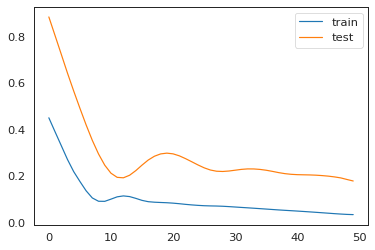

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test


In [ ]:
test_X.shape

(35, 1, 29)

In [ ]:

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(35, 29)
Test RMSE: 0.191


# 2.1 Loading NY - Social Distancing Inertia Labeled data

In [ ]:
NY_inertia_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_sd_inertia_labeledData_Sep26.csv',low_memory=False)
NY_inertia_labeled_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,growth_label_1k,growth_1k_pop
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.3200,40.3000,2.3000,35.4000,1.0600,3.2500,0,307117,0.4000,2020-01-22,6.0600,22,64535,11.7000,5.8000,48.4400,577,465,151,2.7400,0.2200,0.0290,37.0000,27,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000
1,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.2900,35.2000,0.4000,47.9000,1.0400,3.2500,0,61833,-0.7000,2020-01-22,1.0400,27,51862,1.1000,2.1000,49.4600,43,12,106,2.7400,0.2200,0.0290,37.0000,67,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000
2,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.3100,37.6000,1.6000,67.0000,0.2800,4.0300,0,4434,7.0000,2020-01-22,0.3700,36,57552,0.8000,1.6000,51.3000,3,1,249,2.7400,0.2200,0.0290,37.0000,96,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000
3,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.2900,29.4000,1.9000,45.6000,0.9200,3.3800,0,178599,5.7000,2020-01-22,2.4700,26,63348,5.4000,10.0000,49.5100,154,86,144,2.7400,0.2200,0.0290,37.0000,59,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000
4,2020-01-22,New York,36039,0,0,36039,Greene County,36,15,17,4.2200,38.9000,2.3000,53.0000,0.9200,3.3000,0,47491,-4.0000,2020-01-22,1.1300,29,53617,5.8000,5.8000,52.3000,72,24,135,2.7400,0.2200,0.0290,37.0000,78,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000


## Categorical Code

In [ ]:
NY_inertia_labeled_data["label"] = NY_inertia_labeled_data["label"].astype('category')
NY_inertia_labeled_data['spread_category']= NY_inertia_labeled_data["label"].cat.codes

In [ ]:
NY_inertia_labeled_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,growth_label_1k,growth_1k_pop,spread_category
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.3200,40.3000,2.3000,35.4000,1.0600,3.2500,0,307117,0.4000,2020-01-22,6.0600,22,64535,11.7000,5.8000,48.4400,577,465,151,2.7400,0.2200,0.0290,37.0000,27,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000,0
1,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.2900,35.2000,0.4000,47.9000,1.0400,3.2500,0,61833,-0.7000,2020-01-22,1.0400,27,51862,1.1000,2.1000,49.4600,43,12,106,2.7400,0.2200,0.0290,37.0000,67,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000,0
2,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.3100,37.6000,1.6000,67.0000,0.2800,4.0300,0,4434,7.0000,2020-01-22,0.3700,36,57552,0.8000,1.6000,51.3000,3,1,249,2.7400,0.2200,0.0290,37.0000,96,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000,0
3,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.2900,29.4000,1.9000,45.6000,0.9200,3.3800,0,178599,5.7000,2020-01-22,2.4700,26,63348,5.4000,10.0000,49.5100,154,86,144,2.7400,0.2200,0.0290,37.0000,59,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,flat_growth,flat_growth,0.0000,0


In [ ]:
NY_inertia_labeled_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'mask_rule_active',
       'CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
   

In [ ]:
X_inertia_cols = ['New cases', 'mask_rule_active', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption',  'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Confirmed', 'Deaths', 'New deaths', '#days: decreasing ILI cases',
       'COVID death rate', 'New cases/1000 people', 'Active cases/1000 people',
       '#days: decreasing COVID cases', 'Imported COVID cases',
       'rolling_avg_new_cases','date']

In [ ]:
#NY_inertia_labeled_data['Date'] =  pd.to_datetime(NY_inertia_labeled_data['Date'])

## Filter for 'Nassau county'

In [ ]:
nassau_county_inertia_data = NY_inertia_labeled_data[NY_inertia_labeled_data['CTNAME'] == 'Nassau County'][X_inertia_cols]

print(nassau_county_inertia_data.shape)
nassau_county_inertia_data.dtypes

(212, 49)


New cases                                       int64
mask_rule_active                                int64
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person                         float64
New COVID cases                                 int64
Population                                      int64
% change in consumption                       float64
Transit mode share                            float64
% people older than 60                          int64
Median income                                   int64
% African Americans                           float64
% Hispanic Americans        

In [ ]:
nassau_county_inertia_data['date'] = nassau_county_inertia_data['date'].apply(lambda x: parse(x))
#nassau_county_inertia_data.index.name = 'date'
nassau_county_inertia_data.head()

,New cases,mask_rule_active,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
49,0,0,36,16,19,4.3800,33.7000,0.9000,42.6000,0.9800,3.3900,0,1358343,-0.9000,2020-01-22,16.8500,24,111240,11.1000,16.6000,48.6100,2994,1514,157,2.7400,0.2200,0.0290,37.0000,42,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
63,0,0,36,15,19,4.4200,34.1000,0.9000,41.5000,0.9800,3.4400,0,1358343,0.6000,2020-01-23,16.8500,24,111240,11.1000,16.6000,48.6100,2994,1514,157,2.7400,0.2200,0.0290,37.0000,42,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
149,0,0,36,14,18,4.6700,32.9000,1.0000,42.8000,0.9600,3.7100,0,1358343,8.5000,2020-01-24,16.8500,24,111240,11.1000,16.6000,48.6100,2994,1514,157,2.7400,0.2200,0.0290,37.0000,42,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
193,0,0,36,38,27,3.8800,32.2000,1.4000,35.9000,0.4900,3.3900,0,1358343,-0.9000,2020-01-25,16.8500,24,111240,11.1000,16.6000,48.6100,2994,1514,157,2.7400,0.2200,0.0290,37.0000,42,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
269,0,0,36,37,27,3.7500,32.1000,1.7000,40.5000,0.4500,3.3000,0,1358343,-3.5000,2020-01-26,16.8500,24,111240,11.1000,16.6000,48.6100,2994,1514,157,2.7400,0.2200,0.0290,37.0000,42,0.0000,0.9000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000


## Preprocessing data for LSTM

In [ ]:
nassau_county_inertia_data.dtypes

New cases                                              int64
mask_rule_active                                       int64
STFIPS                                                 int64
Social distancing index                                int64
% staying home                                         int64
Trips/person                                         float64
% out-of-county trips                                float64
% out-of-state trips                                 float64
Miles/person                                         float64
Work trips/person                                    float64
Non-work trips/person                                float64
New COVID cases                                        int64
Population                                             int64
% change in consumption                              float64
date                                          datetime64[ns]
Transit mode share                                   float64
% people older than 60  

In [ ]:
nassau_county_inertia_data.shape

(212, 49)

In [ ]:
values = nassau_county_inertia_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,48] = encoder.fit_transform(values[:,48])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  ...  var47(t)  var48(t)  var49(t)
1     0.0000     0.0000     0.0000  ...    0.0000    0.0000    0.0047
2     0.0000     0.0000     0.0000  ...    0.0000    0.0000    0.0095
3     0.0000     0.0000     0.0000  ...    0.0000    0.0000    0.0142
4     0.0000     0.0000     0.0000  ...    0.0000    0.0000    0.0190
5     0.0000     0.0000     0.0000  ...    0.0000    0.0000    0.0237

[5 rows x 98 columns]


## Train test split

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 20 * 24
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


168
values shape  (211, 98)
(168, 1, 97) (168,) (43, 1, 97) (43,)


## Training LSTM

Epoch 1/50
3/3 - 0s - loss: 0.4144 - val_loss: 0.7829
Epoch 2/50
3/3 - 0s - loss: 0.2623 - val_loss: 0.5911
Epoch 3/50
3/3 - 0s - loss: 0.1296 - val_loss: 0.4041
Epoch 4/50
3/3 - 0s - loss: 0.0997 - val_loss: 0.2522
Epoch 5/50
3/3 - 0s - loss: 0.1307 - val_loss: 0.1554
Epoch 6/50
3/3 - 0s - loss: 0.1564 - val_loss: 0.1143
Epoch 7/50
3/3 - 0s - loss: 0.1489 - val_loss: 0.1258
Epoch 8/50
3/3 - 0s - loss: 0.1158 - val_loss: 0.1625
Epoch 9/50
3/3 - 0s - loss: 0.0800 - val_loss: 0.1917
Epoch 10/50
3/3 - 0s - loss: 0.0660 - val_loss: 0.1986
Epoch 11/50
3/3 - 0s - loss: 0.0616 - val_loss: 0.1821
Epoch 12/50
3/3 - 0s - loss: 0.0595 - val_loss: 0.1478
Epoch 13/50
3/3 - 0s - loss: 0.0587 - val_loss: 0.1078
Epoch 14/50
3/3 - 0s - loss: 0.0610 - val_loss: 0.0845
Epoch 15/50
3/3 - 0s - loss: 0.0588 - val_loss: 0.0881
Epoch 16/50
3/3 - 0s - loss: 0.0518 - val_loss: 0.1039
Epoch 17/50
3/3 - 0s - loss: 0.0464 - val_loss: 0.1063
Epoch 18/50
3/3 - 0s - loss: 0.0412 - val_loss: 0.0896
Epoch 19/50
3/3 - 0

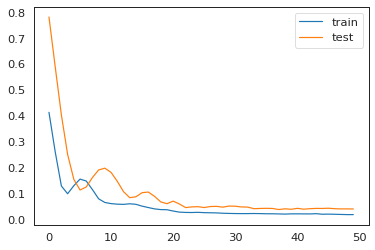

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [ ]:

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(43, 97)
Test RMSE: 0.046


# Reference:

* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/